In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
library(tidyverse)
library(readxl)
library(dplyr)
library(broom)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Load data

The goal here is to determine the if certain environments are enriched for microcins. To do that we need information about the assemblies so that we can determine which environments they came from.


In [3]:
%%R

Australian_Dataset <- read_excel("data/Ecoli_assemblySummary.xlsx", sheet="Australian-Dataset", skip=4) %>%
    select(c("Genome_ID","Phylogroup"))%>%
	rename("phylogroup"="Phylogroup")%>%
    drop_na()

Australian_Dataset 

New names:
• `` -> `...4`
• `` -> `...13`
• `` -> `...14`
• `` -> `...22`
• `` -> `...32`
• `` -> `...37`
• `` -> `...38`
• `` -> `...39`
• `` -> `...40`
• `` -> `...41`
• `` -> `...42`
• `` -> `...50`
• `` -> `...57`
• `` -> `...65`
• `` -> `...71`
• `` -> `...74`
• `` -> `...75`
• `` -> `...76`
• `` -> `...80`
• `` -> `...83`
• `` -> `...84`
# A tibble: 1,294 × 2
   Genome_ID       phylogroup
   <chr>           <chr>     
 1 ESCO.0216.00064 A         
 2 ESCO.0216.00065 B2        
 3 ESCO.0216.00066 B2        
 4 ESCO.0216.00067 B2        
 5 ESCO.0216.00068 B2        
 6 ESCO.0216.00069 B2        
 7 ESCO.0216.00070 B2        
 8 ESCO.0216.00071 B1        
 9 ESCO.0216.00072 B2        
10 ESCO.0216.00073 D         
# … with 1,284 more rows


In [4]:
%%R

assemblySummary_SequencedGenomes <- read_excel("data/Ecoli_assemblySummary.xlsx", 
                                               sheet="Sequenced-Genomes", skip=5) %>%
	select(c("Genome_ID","Isolation source","Strain Category")) %>%
    drop_na()%>%
#Remove 'Alone' and 'Soil' samples
	filter(`Strain Category` != "Alone") %>%
	filter(`Strain Category` != "Soil")%>%
#Removing three further samples that were categorized by Touchon as Alone
    filter(Genome_ID != "ESCO.0216.00100") %>%
    filter(Genome_ID != "ESCO.0216.00262") %>%
    filter(Genome_ID != "ESCO.0216.00275") %>%
#adding in phylogenetic data from above
    full_join(Australian_Dataset, by = "Genome_ID") #%>%
#    drop_na()

assemblySummary_SequencedGenomes #has missing two

New names:
• `` -> `...8`
• `` -> `...20`
• `` -> `...28`
• `` -> `...35`
# A tibble: 1,302 × 4
   Genome_ID       `Isolation source` `Strain Category`      phylogroup
   <chr>           <chr>              <chr>                  <chr>     
 1 ESCO.0216.00064 Host-associated    Mammal_Faecal          A         
 2 ESCO.0216.00065 Environmental      Water                  B2        
 3 ESCO.0216.00066 Host-associated    Human_Extra-intestinal B2        
 4 ESCO.0216.00067 Host-associated    Human_Extra-intestinal B2        
 5 ESCO.0216.00068 Host-associated    Mammal_Faecal          B2        
 6 ESCO.0216.00069 Host-associated    Human_Extra-intestinal B2        
 7 ESCO.0216.00070 Environmental      Water                  B2        
 8 ESCO.0216.00071 Environmental      Water                  B1        
 9 ESCO.0216.00072 Host-associated    Human_Intestinal       B2        
10 ESCO.0216.00073 Host-associated    Human_Intestinal       D         
# … with 1,292 more rows


In [5]:
%%R

best_hits <- read_csv("data/best_hits_Touchon2020_2022.08.15.csv")

best_hits_assemblyID <- best_hits %>%
	separate(cinful_id,c("ASSEMBLY_ACC_ID"), sep="/") %>%
	separate(ASSEMBLY_ACC_ID, c("ASSEMBLY_ACC"), sep = "[.]") %>%
    distinct(ASSEMBLY_ACC, .keep_all = TRUE)%>%
	filter(component == "microcins.verified") %>%
    filter (hmmerHit == TRUE) %>%
    drop_na()

best_hits_assemblyID #286 genomes with microcin hits

Rows: 7537 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 286 × 25
   qseqid        sseqid pident length mismatch gapopen qstart  qend sstart  send
   <chr>         <chr>   <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_db490… H47_s…  100       75        0       0     23    97      1    75
 2 v1_PLS_db490… H47_s…  100       75        0       0     23    97      1    75
 3 v1_PLS_db490… H47_s…  100       75        0       0     23    97      1    75
 4 v1_PLS_db490… H47_s…  100       75        0       0     23    97      1    75
 5 v1

In [6]:
%%R 

assemblySummary_ENAInformation <- read_excel("data/Ecoli_assemblySummary.xlsx", sheet="ENA-Information") %>%
    rename("Genome_ID" = "GEMBASE_NAME")

assemblySummary_Annotated <- assemblySummary_SequencedGenomes %>%
	right_join(assemblySummary_ENAInformation, by="Genome_ID") %>%
	drop_na()

assemblySummary_Annotated #%>% #1213 genomes
#	write_csv("data/supplemental/assemblySummary_Annotated.csv")

# A tibble: 1,213 × 9
   Genome_ID       `Isolation source` `Strain Category` phylogroup ASSEMBLY_NAME
   <chr>           <chr>              <chr>             <chr>      <chr>        
 1 ESCO.0216.00064 Host-associated    Mammal_Faecal     A          M919         
 2 ESCO.0216.00065 Environmental      Water             B2         E5795        
 3 ESCO.0216.00066 Host-associated    Human_Extra-inte… B2         H219         
 4 ESCO.0216.00069 Host-associated    Human_Extra-inte… B2         H144         
 5 ESCO.0216.00070 Environmental      Water             B2         E7727        
 6 ESCO.0216.00071 Environmental      Water             B1         E2508        
 7 ESCO.0216.00072 Host-associated    Human_Intestinal  B2         54_1_Ti6     
 8 ESCO.0216.00073 Host-associated    Human_Intestinal  D          47_4_R1      
 9 ESCO.0216.00074 Host-associated    Mammal_Faecal     B2         M714         
10 ESCO.0216.00075 Environmental      Water             B2         E7615        
# … wi

In [7]:
%%R

best_hits_assemblyID_Annotated <- best_hits_assemblyID %>% #this contains 286 microcin hits
	left_join(assemblySummary_Annotated) %>% #this contains 1213 genomes with other information
	select(ASSEMBLY_ACC, phylogroup, sseqid, verified, `Strain Category`) %>%
    drop_na(c(`Strain Category`, verified))


best_hits_assemblyID_Annotated

Joining, by = "ASSEMBLY_ACC"
# A tibble: 284 × 5
   ASSEMBLY_ACC  phylogroup sseqid                     verified `Strain Catego…`
   <chr>         <chr>      <chr>                      <lgl>    <chr>           
 1 GCA_902858915 F          H47_sp_P62530_MCHB_ECOLX   FALSE    Human_Intestinal
 2 GCA_902846155 B1         H47_sp_P62530_MCHB_ECOLX   FALSE    Human_Intestinal
 3 GCA_902849625 G          H47_sp_P62530_MCHB_ECOLX   FALSE    Human_Faecal    
 4 GCA_902840795 D          H47_sp_P62530_MCHB_ECOLX   FALSE    Mammal_Faecal   
 5 GCA_902840495 B1         H47_sp_P62530_MCHB_ECOLX   FALSE    Mammal_Faecal   
 6 GCA_902844105 A          H47_sp_P62530_MCHB_ECOLX   FALSE    Human_Faecal    
 7 GCA_902846895 B1         H47_sp_P62530_MCHB_ECOLX   FALSE    Water           
 8 GCA_902842745 B1         H47_sp_P62530_MCHB_ECOLX   FALSE    Water           
 9 GCA_902844605 A          I47_tr_Q712Q0_Q712Q0_ECOLX FALSE    Human_Extra-int…
10 GCA_902849245 G          V_sp_P22522_CEAV_ECOLX     FALSE

In [8]:
%%R

hits_phylogroup_by_category <- table(best_hits_assemblyID_Annotated$phylogroup, best_hits_assemblyID_Annotated$`Strain Category`)

table(best_hits_assemblyID_Annotated$phylogroup, best_hits_assemblyID_Annotated$`Strain Category`)

sum(table(best_hits_assemblyID_Annotated$phylogroup, best_hits_assemblyID_Annotated$`Strain Category`))

[1] 284


In [9]:
%%R

all_phylogroup_by_category <- table(assemblySummary_Annotated$phylogroup, assemblySummary_Annotated$`Strain Category`)

table(assemblySummary_Annotated$phylogroup, assemblySummary_Annotated$`Strain Category`)

    
     Bird_Faecal Human_Extra-intestinal Human_Faecal Human_Intestinal
  A           51                     19           35               20
  B1          46                      1            0               28
  B2          31                     64           22               73
  C            1                      5            4                1
  D           29                      0            0               44
  E            8                      0            0                1
  F           17                     13            7                5
  G            2                      2            4                0
    
     Mammal_Faecal Poultry_Meat Water
  A             21           89    56
  B1            27           48   123
  B2            35           37    38
  C              0            4     1
  D             27           43    31
  E              4           28    15
  F              3           17     9
  G              0           17     7


In [10]:
%%R

#Frequency of microcin per assembly
microcinAssemblyProportion <- length(best_hits_assemblyID_Annotated$ASSEMBLY_ACC)/length(assemblySummary_Annotated$ASSEMBLY_ACC)

print(length(best_hits_assemblyID_Annotated$ASSEMBLY_ACC))
print("/")
print(length(assemblySummary_Annotated$ASSEMBLY_ACC))
print("=")
print(microcinAssemblyProportion)


[1] 284
[1] "/"
[1] 1213
[1] "="
[1] 0.2341303


In [11]:
%%R
strain_category_assemblies <- assemblySummary_Annotated %>%
	count(`Strain Category`, name="total_assemblies")
strain_category_assemblies

# A tibble: 7 × 2
  `Strain Category`      total_assemblies
  <chr>                             <int>
1 Bird_Faecal                         185
2 Human_Extra-intestinal              104
3 Human_Faecal                         72
4 Human_Intestinal                    172
5 Mammal_Faecal                       117
6 Poultry_Meat                        283
7 Water                               280


In [12]:
%%R -w 1500

microcin_strain_category <- best_hits_assemblyID_Annotated %>%
	count(`Strain Category`, name = "microcin") %>%
	full_join(strain_category_assemblies) %>%
	mutate(relative_microcin = microcin / total_assemblies) %>%
	mutate(odds = relative_microcin/(microcinAssemblyProportion)) %>%
	mutate(LOE = log10(odds)) %>%
	drop_na() 
#microcin_strain_category <- microcin_strain_category %>%
#	mutate(assembly_freq = total_assemblies#/sum(total_assemblies)

microcin_strain_category


Joining, by = "Strain Category"
# A tibble: 7 × 6
  `Strain Category`    microcin total_assemblies relative_microc…  odds      LOE
  <chr>                   <int>            <int>            <dbl> <dbl>    <dbl>
1 Bird_Faecal                42              185           0.227  0.970 -0.0134 
2 Human_Extra-intesti…       46              104           0.442  1.89   0.276  
3 Human_Faecal               17               72           0.236  1.01   0.00366
4 Human_Intestinal           33              172           0.192  0.819 -0.0865 
5 Mammal_Faecal              26              117           0.222  0.949 -0.0227 
6 Poultry_Meat               94              283           0.332  1.42   0.152  
7 Water                      26              280           0.0929 0.397 -0.402  


In [13]:
%%R
#Chi square present in paper before figure 5

microcin_strain_category_chisq <- chisq.test(microcin_strain_category$total_assemblies)
microcin_strain_category_chisq


	Chi-squared test for given probabilities

data:  microcin_strain_category$total_assemblies
X-squared = 241.17, df = 6, p-value < 2.2e-16



In [14]:
%%R

freqs = microcin_strain_category$total_assemblies/sum(microcin_strain_category$total_assemblies)

microcin_strain_category_freq_chisq <- chisq.test(x = microcin_strain_category$microcin, p=freqs)

microcin_strain_category_freq_chisq


	Chi-squared test for given probabilities

data:  microcin_strain_category$microcin
X-squared = 56.158, df = 6, p-value = 2.705e-10



In [15]:
%%R
microcin_strain_category #<- microcin_strain_category %>%
microcin_strain_category$`Strain Category` <- c("Bird Fecal", "Human Extraintestinal", "Human Fecal", "Human Intestinal", "Mammal Fecal", "Poultry Meat", "Water")

#	write_csv("data/supplemental/Touchon_categories_microcins.csv")

microcin_strain_category %>%
    bind_rows(summarise_all(., ~if(is.numeric(.)) sum(.) else "Total"))



# A tibble: 8 × 6
  `Strain Category`    microcin total_assemblies relative_microc…  odds      LOE
  <chr>                   <int>            <int>            <dbl> <dbl>    <dbl>
1 Bird Fecal                 42              185           0.227  0.970 -0.0134 
2 Human Extraintestin…       46              104           0.442  1.89   0.276  
3 Human Fecal                17               72           0.236  1.01   0.00366
4 Human Intestinal           33              172           0.192  0.819 -0.0865 
5 Mammal Fecal               26              117           0.222  0.949 -0.0227 
6 Poultry Meat               94              283           0.332  1.42   0.152  
7 Water                      26              280           0.0929 0.397 -0.402  
8 Total                     284             1213           1.74   7.45  -0.0924 


In [16]:
%%R

touchon <- microcin_strain_category %>%
    select(c(`Strain Category`,total_assemblies,microcin)) %>%
	rename("group"="Strain Category") %>%
	rename("samples"="total_assemblies") %>%
	rename("hits"="microcin")

samples_tot <- sum(touchon$samples)
hits_tot <- sum(touchon$hits)

fisher_results <- touchon %>%
  mutate(
    fit = map2(
      samples, hits,
      ~fisher.test(cbind(c(samples_tot, .x), c(hits_tot, .y)))
    ),
    glance_out = map(fit, glance)
  ) %>%
  select(group, glance_out) %>%
  unnest(cols = glance_out) %>%
  mutate(
    # adjust for multiple testing
    p.adj = p.adjust(p.value, method = "fdr"),
    # sort
    group = fct_reorder(group, estimate),
    # significance label
    label = case_when(
      p.adj < 0.001 ~ "***",
      p.adj < 0.01 ~ "**",
      p.adj < 0.05 ~ "*",
      TRUE ~ ""
    ),
    # for label justification
    hjust = ifelse(estimate < 1, 1.1, -0.1)
  ) %>%
  rename(
    odds_ratio = estimate
  )

fisher_results

# A tibble: 7 × 10
  group   odds_ratio p.value conf.low conf.high method alternative   p.adj label
  <fct>        <dbl>   <dbl>    <dbl>     <dbl> <chr>  <chr>         <dbl> <chr>
1 Bird F…      0.970 9.28e-1    0.660     1.40  Fishe… two.sided   1   e+0 ""   
2 Human …      1.89  1.22e-3    1.27      2.77  Fishe… two.sided   4.28e-3 "**" 
3 Human …      1.01  1   e+0    0.548     1.76  Fishe… two.sided   1   e+0 ""   
4 Human …      0.820 3.41e-1    0.535     1.23  Fishe… two.sided   5.96e-1 ""   
5 Mammal…      0.949 9.11e-1    0.584     1.49  Fishe… two.sided   1   e+0 ""   
6 Poultr…      1.42  1.19e-2    1.07      1.86  Fishe… two.sided   2.77e-2 "*"  
7 Water        0.397 2.83e-6    0.250     0.608 Fishe… two.sided   1.98e-5 "***"
# … with 1 more variable: hjust <dbl>


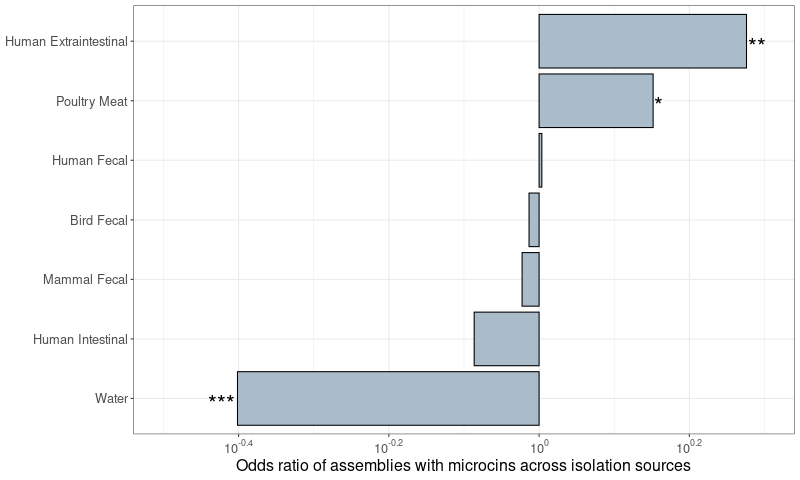

In [17]:
%%R -w 800

ggplot(fisher_results, aes(x = odds_ratio, y = reorder(group, odds_ratio)), log="x") +
    geom_col() +
    geom_text(aes(label = label, hjust = hjust), size = 8, vjust = 0.8) +
    scale_x_log10(
        limits = c(10^-0.5, 10^0.3),
        breaks = scales::trans_breaks("log10", function(x) 10^x),
        labels = scales::trans_format("log10", scales::math_format(10^.x))
                )+
    geom_bar(stat = "identity", position = "identity", fill = "#aabbcaff", color="black") +
        ylab(NULL) + 
        xlab("Odds ratio of assemblies with microcins across isolation sources") +
        theme_bw() +
        theme(text = element_text(size = 16))

#ggsave("plots/05_ecoli_microcin_environment_updated_hmm_final.svg")